## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Calibrate the Camera

In [9]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
# Helper Methods
def save_image(fname, img, img_num):
    cv2.imwrite('./output_images/{}{}.jpg'.format(fname, img_num), img)

# Loading camera calibration
cameraCalibration = pickle.load( open('./calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

In [10]:
# Load test images.
test_images = list(map(
    lambda imageFileName: (imageFileName, cv2.imread(imageFileName)),
    glob.glob('./test_images/*.jpg')
))

## Undistort Images with Calibrated Camera

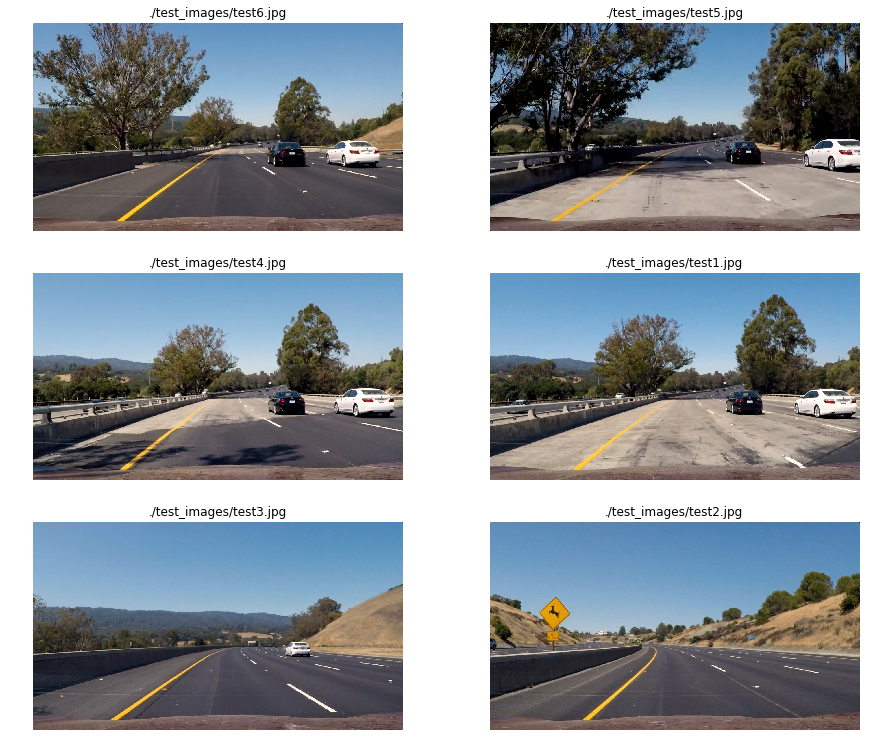

In [11]:
def display_images(images, cols = 4, rows = 5, figsize=(15,10), cmap = None):
    """
    Show a list of images in grid format using matplotlib
    """
    img_length = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    
    for ax, index in zip(axes.flat, indexes):
        if index < img_length:
            image_path, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(image_path)
            ax.axis('off')
        
display_images(list(map(lambda img: (img[0], cv2.cvtColor(img[1], cv2.COLOR_BGR2RGB)), test_images)), 2, 3, (15, 13))

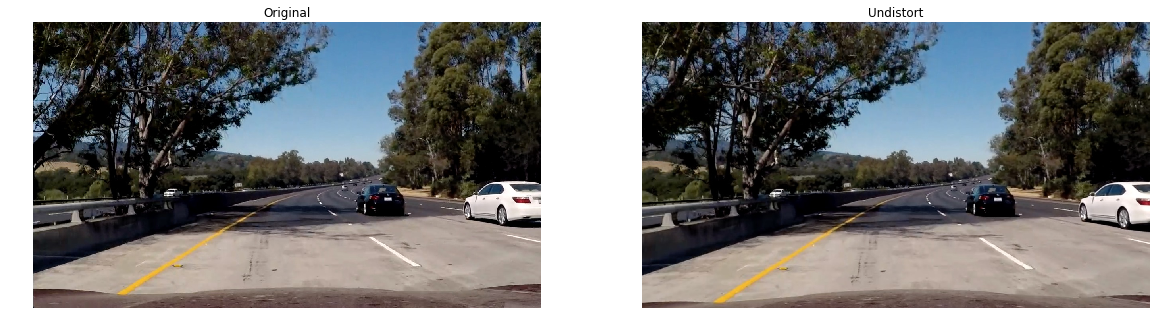

In [12]:
def display_comparison(img_l, title_l, img_r, title_r, figsize=(20,10) , cmap_l=None, cmap_r=None):
    """
    Display a comparison of the output of some transform on a specified image.
    """
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    left_axes, right_axes = axes
    
    if cmap_l == None:
        left_axes.imshow(img_l)
    else:
        left_axes.imshow(img_l, cmap=cmap_l)
    left_axes.set_title(title_l)
    left_axes.axis('off')
    if cmap_r == None:
        right_axes.imshow(img_r)
    else:
        right_axes.imshow(img_r, cmap=cmap_r)
    right_axes.set_title(title_r)
    right_axes.axis('off')
    

original = test_images[1][1]
display_comparison(
    cv2.cvtColor(original, cv2.COLOR_BGR2RGB), 'Original',
    cv2.cvtColor(cv2.undistort(original, mtx, dist, None, mtx), cv2.COLOR_BGR2RGB), 'Undistort'
)

In [13]:
def undistort_and_hls(image, mtx=mtx, dist=dist):
    """
    Undistort and convert an image to HLS color space.
    """
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)

In [14]:
get_s_channel = lambda img: undistort_and_hls(img)[:,:,2]

## Transform Perspective to Find Lane Curvature

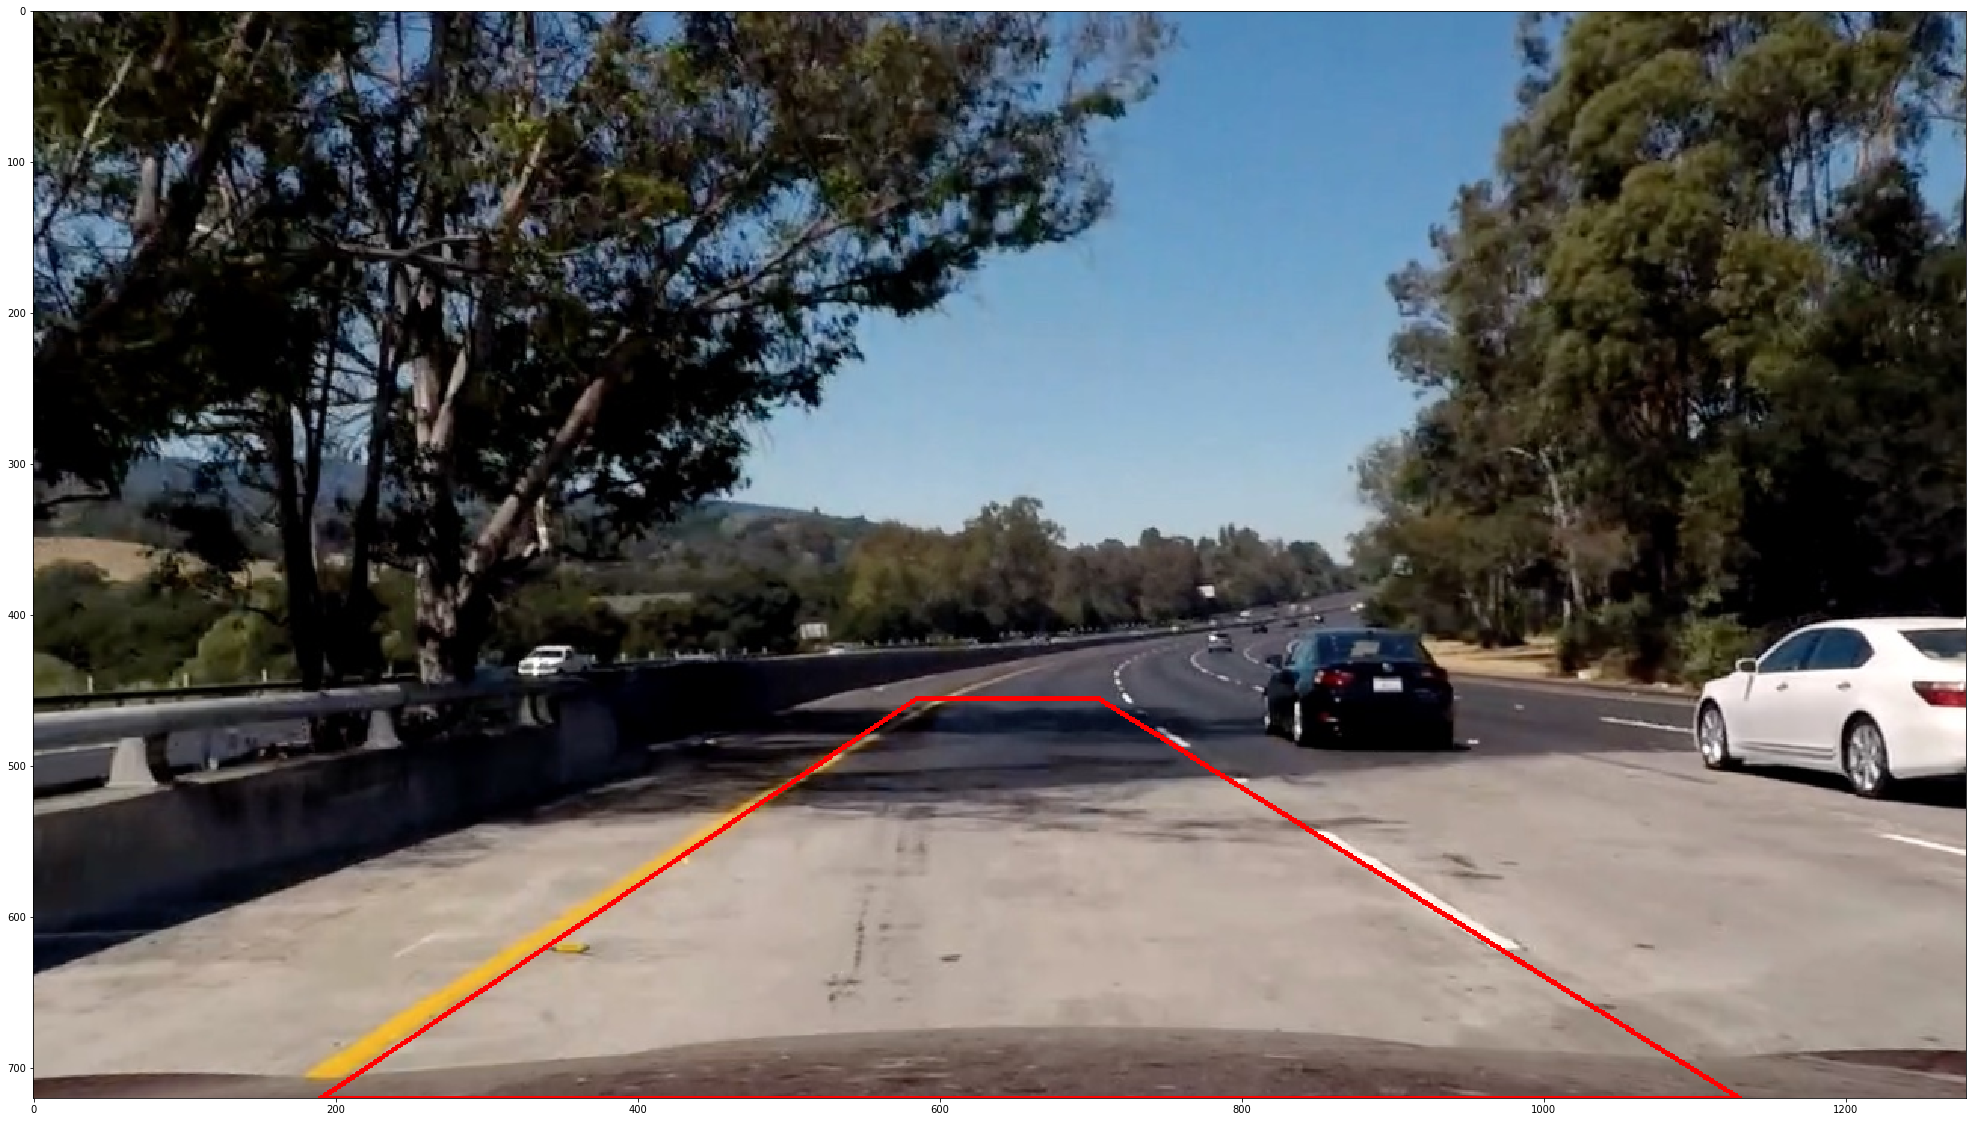

In [15]:
original = cv2.cvtColor(test_images[1][1],cv2.COLOR_BGR2RGB)
undist = cv2.undistort(original, mtx, dist, None, mtx)
copy = undist.copy()

def draw_line(x,  y): 
    cv2.line(copy, x, y, [255, 0, 0], 2)

bottom_y = 720
top_y = 455

L1 = (190, bottom_y)
L2 = (585, top_y)

L1_x, L1_y = L1
L2_x, L2_y = L2

R1 = (705, top_y)
R2 = (1130, bottom_y)

R1_x, R1_y = R1
R2_x, R2_y = R2

draw_line(L1, L2)
draw_line(L2, R1)
draw_line(R1, R2)
draw_line(R2, L1)

fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(copy)

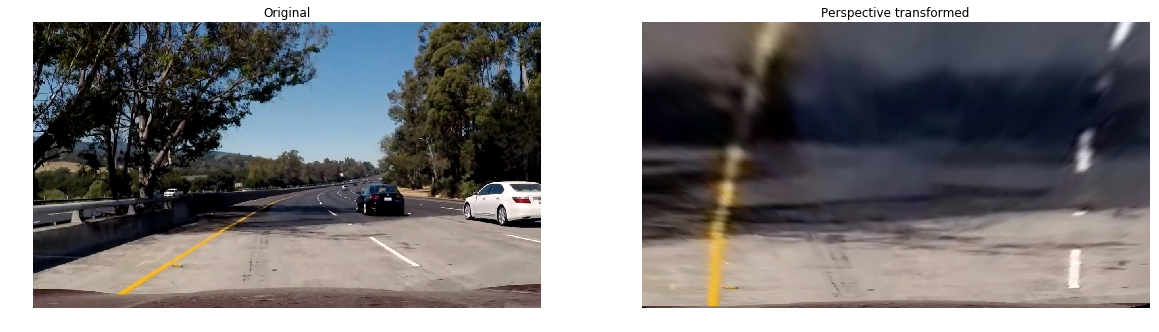

In [16]:
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

ny, nx = gray.shape
img_size = (nx, ny)
offset = 200

src = np.float32([ 
    [L2_x, L2_y],
    [R1_x, R1_y],
    [R2_x, R2_y],
    [L1_x, L1_y]
])

dst = np.float32([
    [offset, 0],
    [nx - offset, 0],
    [nx - offset, ny], 
    [offset, ny]
])


M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undist, M, img_size)

display_comparison(
    original, 'Original',
    warped, 'Perspective transformed'
)

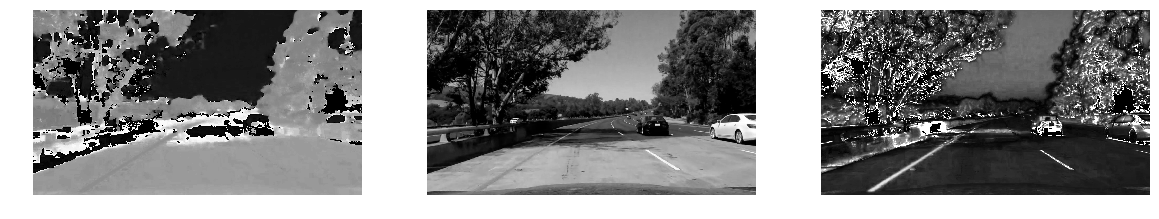

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(20,10))
hlsImg = undistort_and_hls(original)
for index, a in enumerate(axes):
    a.imshow(hlsImg[:,:,index], cmap='gray')
    a.axis('off')

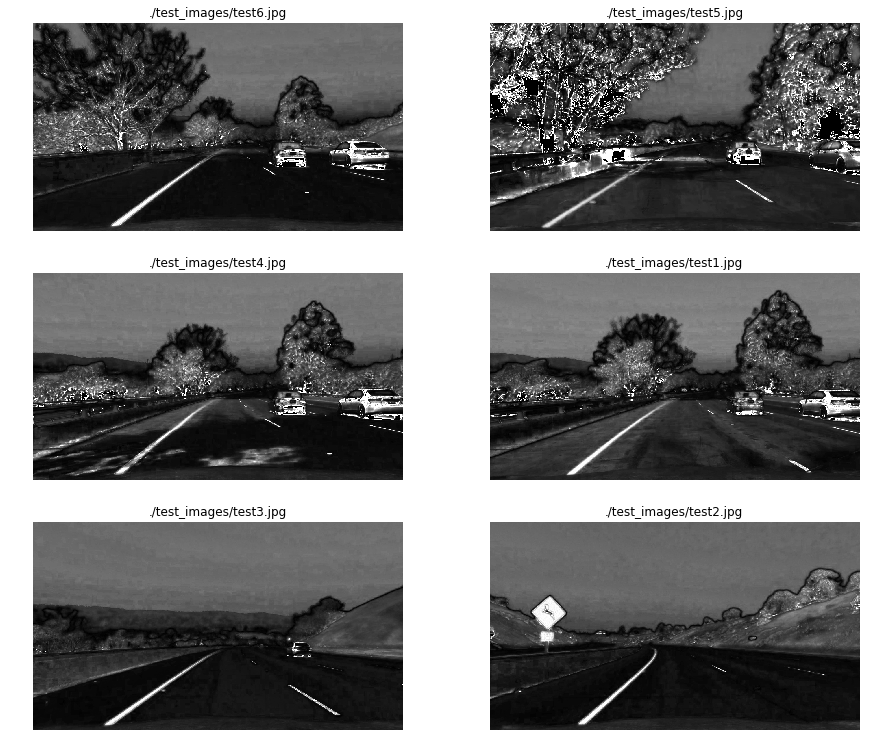

In [18]:
def transform_collection_images(collection, transform):
    return list(map(lambda imgDataTuple: (imgDataTuple[0], transform(imgDataTuple[1])), collection))

def display_transformed_images(collection, transform):
    result = transform_collection_images(collection, transform)
    display_images(result, 2, 3, (15, 13), cmap='gray')
    return result

s_channel_images = display_transformed_images(test_images, get_s_channel)

# Apply Binary Thresholds to Determine Lane Lines

# Sobel X

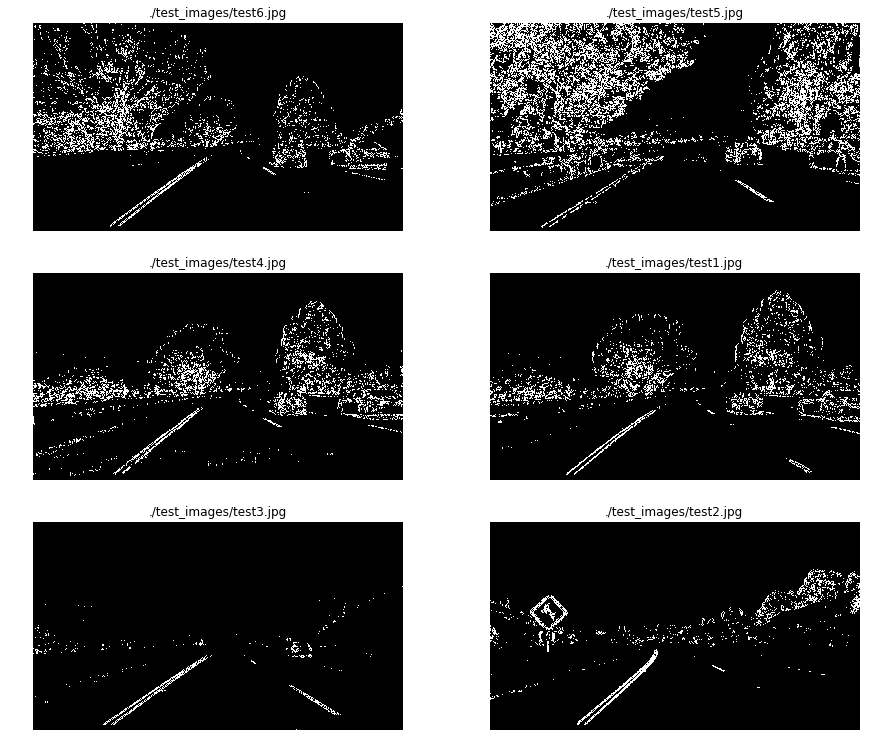

In [19]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    
    thresh_min, thresh_max = thresh
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

sobel_config = {'sobel_kernel': 9, 'thresh': (20, 150)}

apply_sobel_x = lambda image: abs_sobel_thresh(get_s_channel(image), orient='x', **sobel_config)
sobel_x = display_transformed_images(test_images, apply_sobel_x)

## Sobel Y

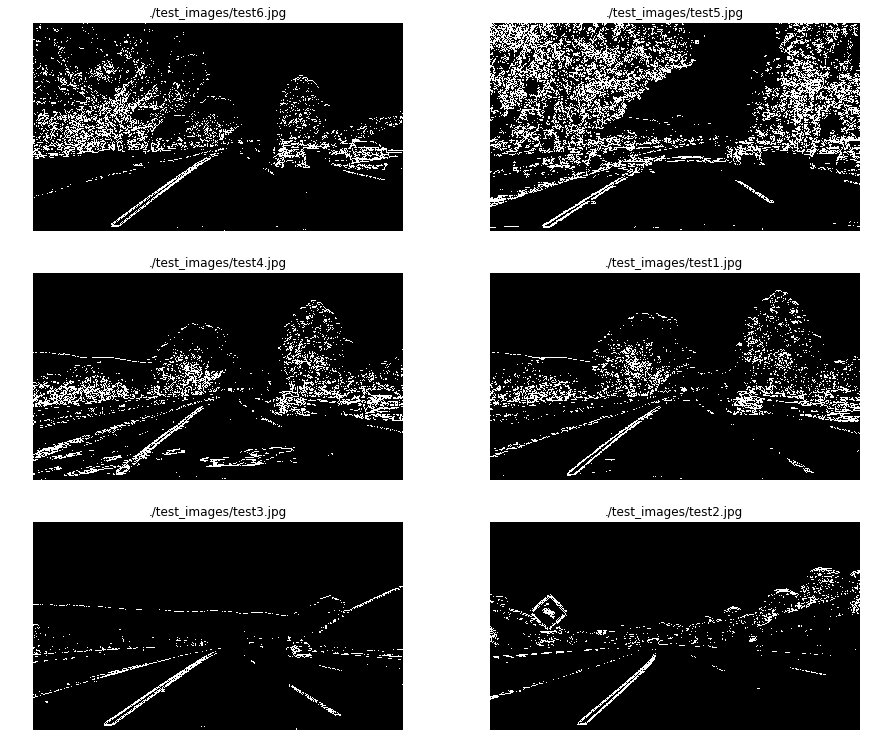

In [20]:
apply_sobel_y = lambda image: abs_sobel_thresh(get_s_channel(image), orient='y', **sobel_config)
sobel_y = display_transformed_images(test_images, apply_sobel_y)

## Gradient Magnitude

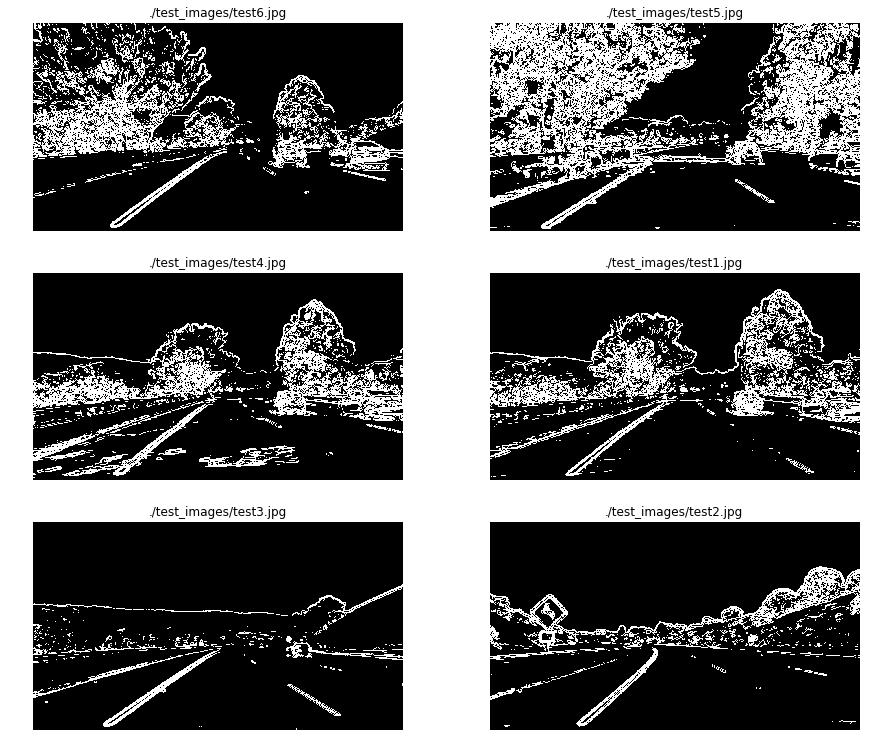

In [21]:
def mag_threshold(image, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return mag_binary

mag_config = {'sobel_kernel': 9, 'thresh': (20, 150)}

apply_magnitude = lambda image: mag_threshold(get_s_channel(image), **mag_config)
magnitude = display_transformed_images(test_images, apply_magnitude)

## Direction Threshold

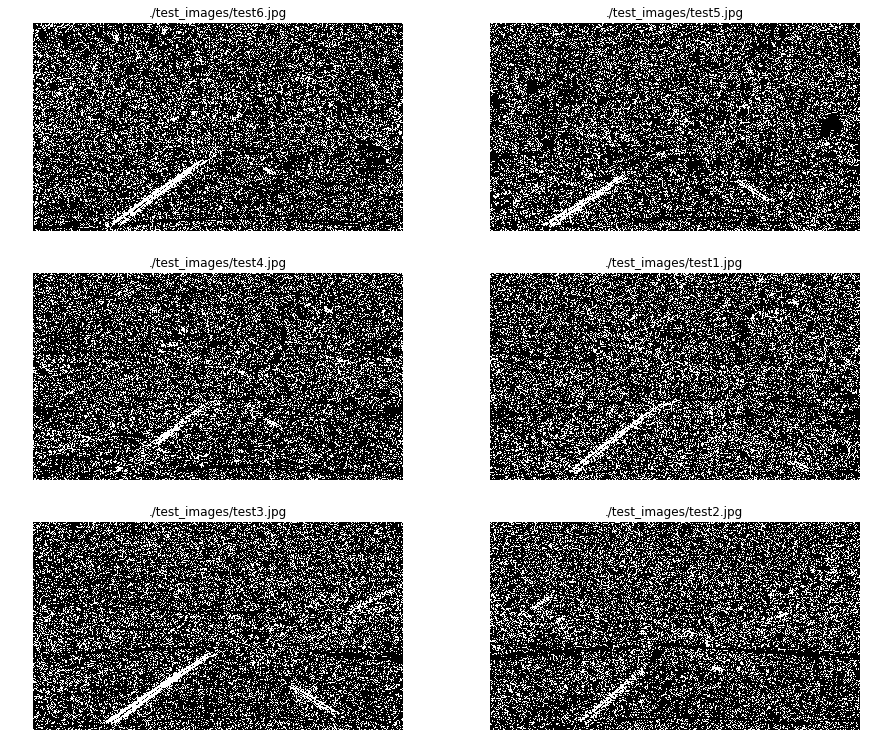

In [22]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary

dir_config = {'sobel_kernel': 9, 'thresh': (0.8, 1.20)}

apply_direction = lambda image: dir_threshold(get_s_channel(image), **dir_config)
direction = display_transformed_images(test_images, apply_direction)

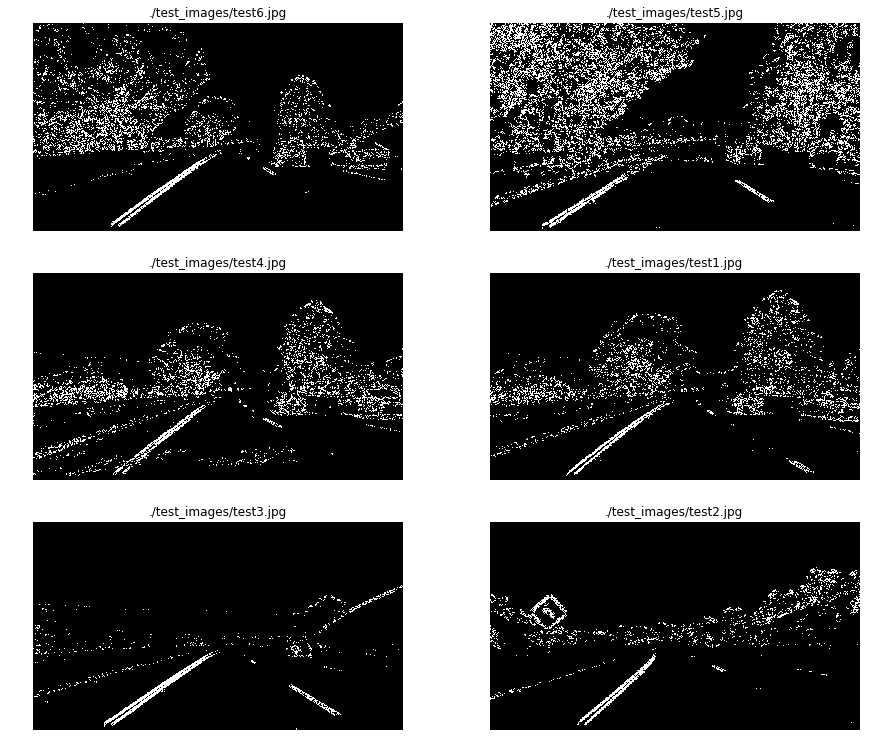

In [23]:
def apply_binary_thresholding(img):
    sobel_x = apply_sobel_x(img)
    sobel_y = apply_sobel_y(img)
    mag = apply_magnitude(img)
    direction = apply_direction(img)
    combined = np.zeros_like(sobel_x) 
    combined[((sobel_x == 1) & (sobel_y == 1)) | ((mag == 1) & (direction == 1))] = 1

    return combined
    
combined_thresholding = display_transformed_images(test_images, apply_binary_thresholding)

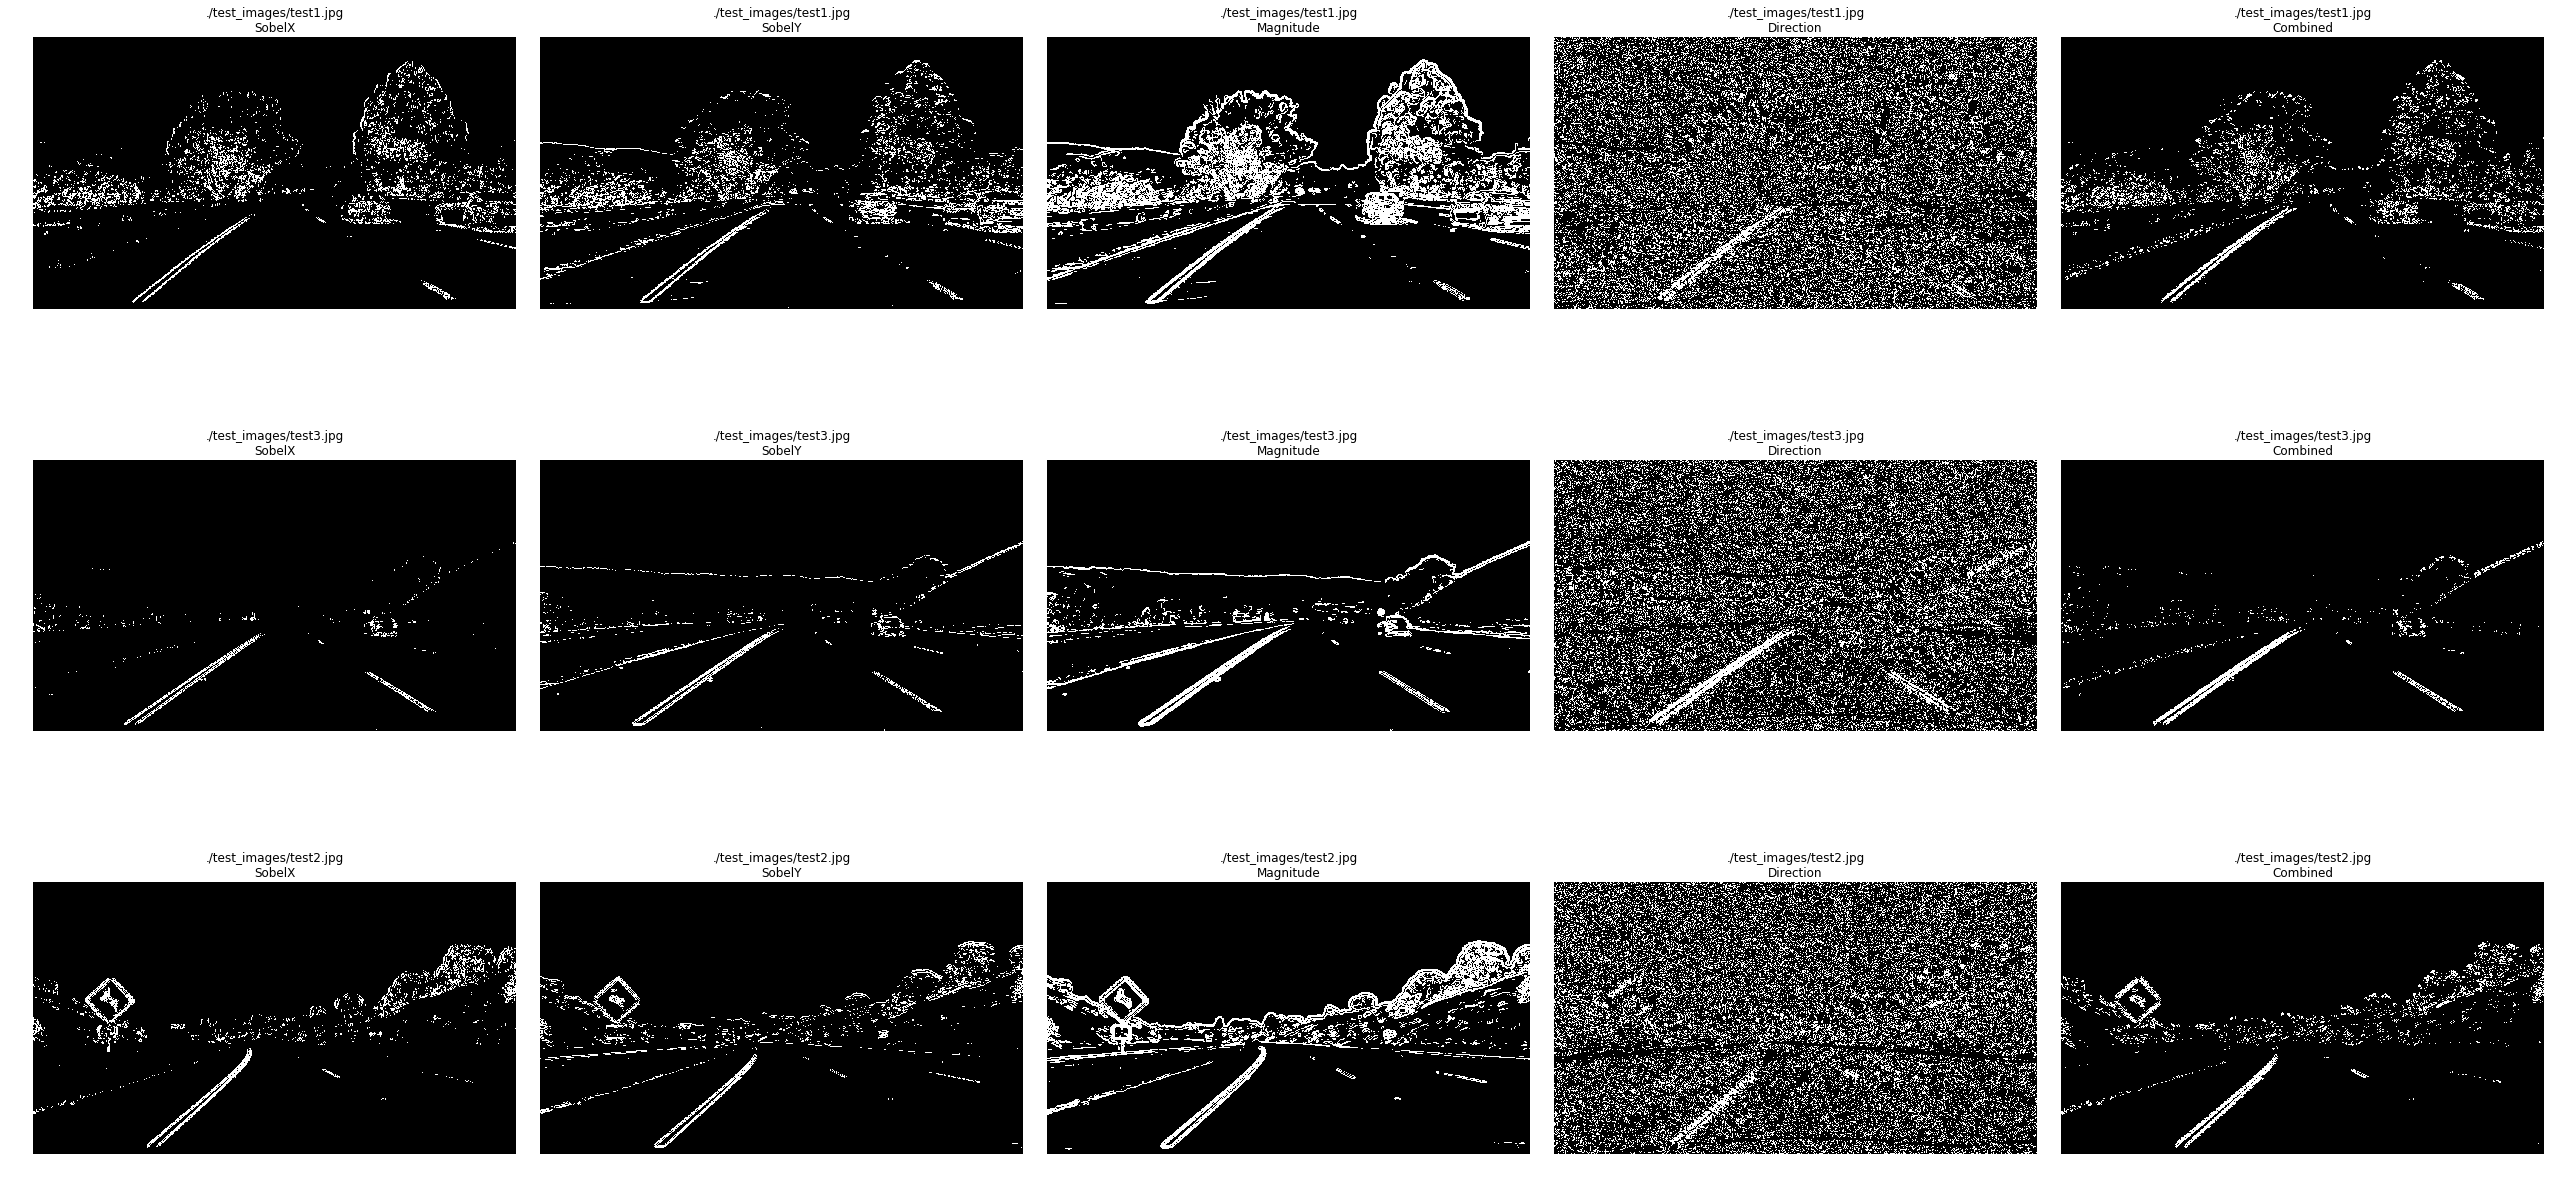

In [24]:
titles = ['SobelX', 'SobelY', 'Magnitude', 'Direction', 'Combined']
thresholds = list(zip( sobel_x, sobel_y, magnitude, direction, combined_thresholding ))

titled_thresholds = list(map(lambda images: list(zip(titles, images)), thresholds))[3:6]
formatted_threshold_examples = [item for sublist in titled_thresholds for item in sublist]

fig, axes = plt.subplots(ncols=5, nrows=len(titled_thresholds), figsize=(45,20))
for ax, thresholds in zip(axes.flat, formatted_threshold_examples):
    title, images = thresholds
    image_path, img = images
    ax.imshow(img, cmap='gray')
    ax.set_title(image_path + '\n' + title, fontsize=12)
    ax.axis('off')
fig.subplots_adjust(hspace=0, wspace=0.05, bottom=0)

## Detect Start of Lane Lines with Histogram

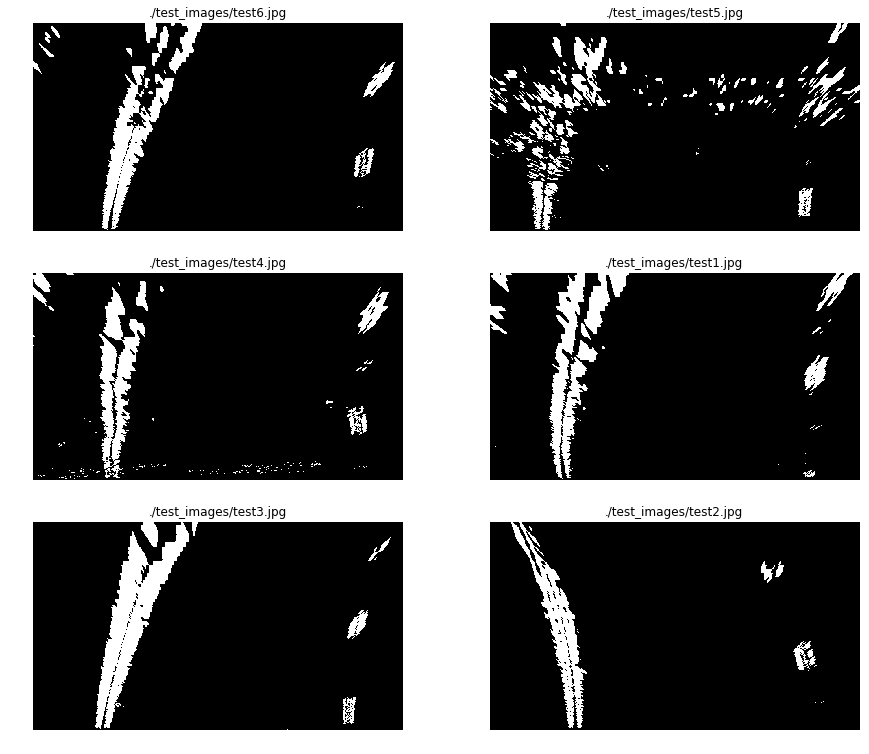

In [25]:
def warp(img, M=M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

threshold_and_warp = lambda img: warp(apply_binary_thresholding(img))
transformed = display_transformed_images(test_images, threshold_and_warp)

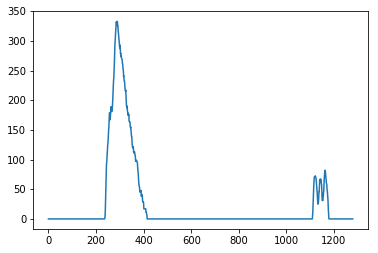

In [26]:
# Create histogram of image binary activations
def hist(img):
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

histogram = hist(transformed[0][1])
plt.plot(histogram)

## Detect Lane Lines Using a Sliding Window

In [45]:
class Lines():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fitx = None
        self.right_fitx = None
        self.curvature = None
        self.ploty = None
        

In [46]:
def find_lane_pixels(binary_warped, nwindows=9, margin=110, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [47]:
def fit_poly(img_shape, leftx, lefty, rightx, righty, lines):
     # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    lines.right_fit = right_fit
    lines.left_fit = left_fit
    lines.right_fitx = right_fitx
    lines.left_fitx = left_fitx
    lines.ploty = ploty
    
    return left_fitx, right_fitx, ploty

In [48]:
def search_around_poly(binary_warped, lines):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = (
      (nonzerox > (
        lines.left_fit[0]*(nonzeroy**2) +
        lines.left_fit[1]*nonzeroy +
        lines.left_fit[2] - margin)
      ) &
      (nonzerox < (
        lines.left_fit[0]*(nonzeroy**2) +
        lines.left_fit[1]*nonzeroy +
        lines.left_fit[2] + margin)
      )
    )

    right_lane_inds = (
      (nonzerox > (
        lines.right_fit[0]*(nonzeroy**2) +
        lines.right_fit[1]*nonzeroy +
        lines.right_fit[2] - margin)
      ) & 
      (nonzerox < (
        lines.right_fit[0]*(nonzeroy**2) +
        lines.right_fit[1]*nonzeroy +
        lines.right_fit[2] + margin)
      )
    )

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty, lines)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

    return result

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  after removing the cwd from sys.path.


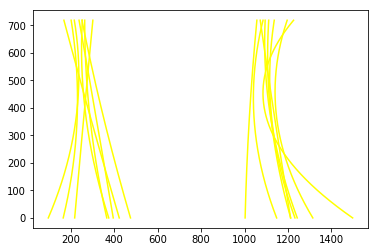

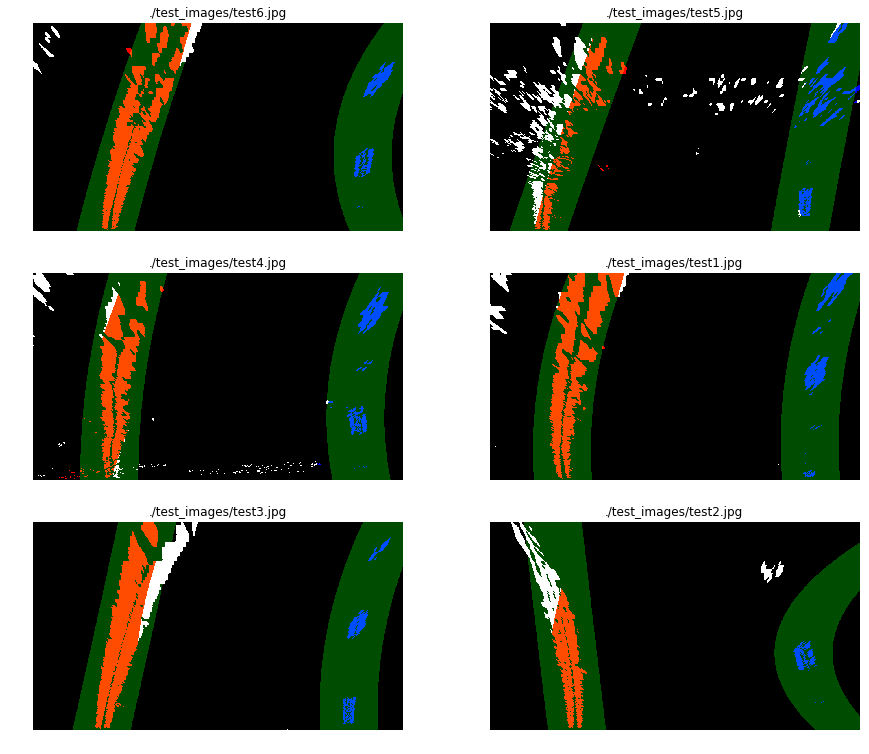

In [49]:
lines = Lines()
def find_lines_and_display(image):
    binary_warped = threshold_and_warp(image)
    if lines.left_fit == None:
        leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

        lines.left_fit = np.polyfit(lefty, leftx, 2)
        lines.right_fit = np.polyfit(righty, rightx, 2)
        return search_around_poly(binary_warped, lines)
    else:
        return search_around_poly(binary_warped, lines)
        
sliding_windows = display_transformed_images(test_images, find_lines_and_display)

In [61]:
def measure_curvature_real(right_fit, left_fit, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2])) /2 - 640)*xm_per_pix
    
    return left_curverad, right_curverad, center

In [129]:
def draw_curvature_info(img, left_curv, right_curv, center_off):
    # Display lane curvature and center offset
    curvature_info = [
        "Left curv: {:.2f}m".format(left_curv),
        "Right curv: {:.2f}m".format(right_curv),
        "Center offset: {:.2f}m".format(center_off)
    ]
    
    scale = 2.25
    thickness = 2
    font = cv2.FONT_HERSHEY_DUPLEX
    color = (255,255,255)
    lineType = cv2.LINE_AA
    
    base = 40
    multiplier = 120
    
    for i, info in enumerate(curvature_info):
        line_height = base + (multiplier * i)
        cv2.putText(img, info, (130, line_height), font, scale, color, lineType=lineType, bottomLeftOrigin=True)
        
    return img

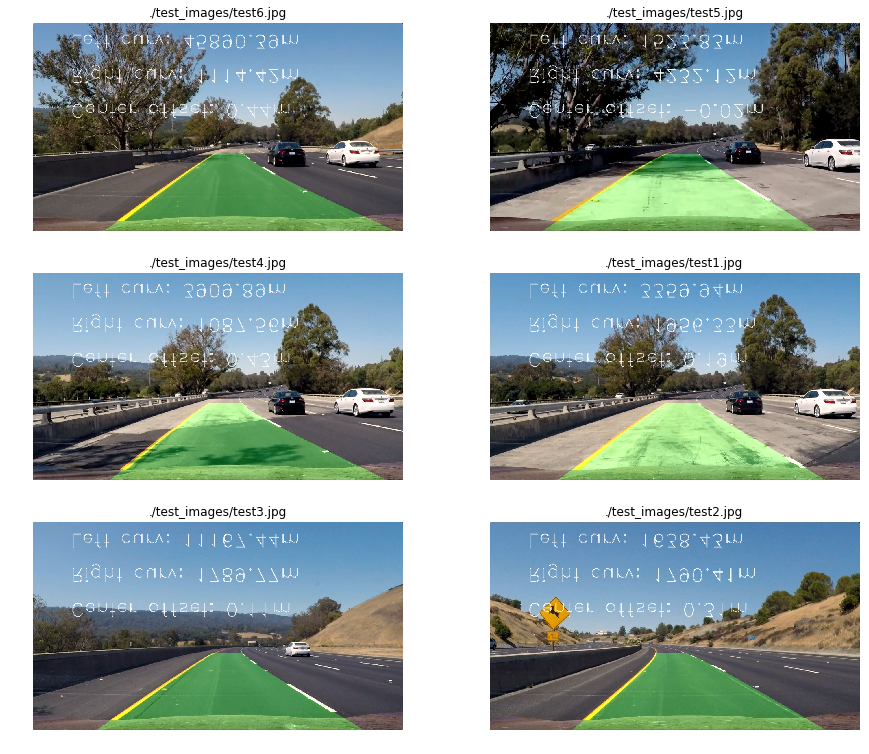

In [130]:
def draw_lanes_on_road(img):
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    binary_warped = threshold_and_warp(img)
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_curv, right_curv, center_off = measure_curvature_real(right_fit, left_fit, ploty)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))    
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    lanes = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return draw_curvature_info(lanes, left_curv, right_curv, center_off)

def display_image_with_lane(img):
    output = draw_lanes_on_road(img)
    return cv2.cvtColor(output, cv2.COLOR_BGR2RGB )

lanes = display_transformed_images(test_images, display_image_with_lane)